In [1]:
%pip install qiskit-nature
%pip install pyscf
%pip install qiskit==1.4.2
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Electronic structure

## Introduction 

The molecular Hamiltonian is 

$$
\mathcal{H} = - \sum_I \frac{\nabla_{R_I}^2}{M_I} - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|} + \sum_I\sum_{J>I} \frac{Z_I Z_J e^2}{|R_I-R_J|}
$$

Because the nuclei are much heavier than the electrons they do not move on the same time scale and therefore, the behavior of nuclei and electrons can be decoupled. This is the Born-Oppenheimer approximation.

Therefore, one can first tackle the electronic problem with the nuclear coordinates entering only as parameters. The energy levels of the electrons in the molecule can then be found by solving the non-relativistic time independent Schrödinger equation,

$$
\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle
$$

where 

$$
\mathcal{H}_{\text{el}} = - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|}.
$$

In particular the ground state energy is given by:
$$
E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$
where $\Psi_0$ is the ground state of the system. 

However, the dimensionality of this problem grows exponentially with the number of degrees of freedom. To tackle this issue we would like to prepare $\Psi_0$ on a quantum computer and measure the Hamiltonian expectation value (or $E_0$) directly. 

So how do we do that concretely? 


## Starting from the Hartree-Fock solution 

A good starting point for solving this problem is the Hartree-Fock (HF) method. This method approximates the N-body problem by N one-body problems where each electron evolves in the mean-field of the others. Classically solving the HF equations is efficient and leads to the exact exchange energy but does not include any electron correlation. Therefore, it is usually a good starting point to which to add correlation. 

The Hamiltonian can then be re-expressed in the basis of the solutions of the HF method, also called Molecular Orbitals (MOs):

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the 1-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)dr
$$
and 2-body integrals
$$
h_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}dr_1dr_2.
$$

The MOs ($\phi_u$) can be occupied or virtual (unoccupied). One MO can contain 2 electrons. However, in what follows we actually work with Spin Orbitals which are associated with a spin up ($\alpha$) of spin down ($\beta$) electron. Thus Spin Orbitals can contain one electron or be unoccupied.

Note: when referring to the number of orbitals, we will be using the number of _spatial_ orbitals. This refers to any orbital in Cartesian space (whether its a molecular orbital or in another basis does not matter here). Each spatial orbital is then generally split into two _spin_ orbitals.

We now show how to concretely realise these steps with Qiskit.

### Obtaining an initial Hartree-Fock solution

Qiskit is interfaced with different classical codes which are able to find the HF solutions. Interfacing between Qiskit and the following codes is already available:

* Gaussian
* Psi4
* PySCF

In the following we set up a PySCF driver, for the hydrogen molecule at equilibrium bond length (0.735 angstrom) in the singlet state and with no charge. 

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

Running this driver, will yield an `ElectronicStructureProblem`, Qiskit Nature's representation of the electronic structure problem which we are interested in solving. For further information about the drivers, see https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.drivers.html

In [3]:
problem = driver.run()
print(problem)

### The `ElectronicStructureProblem` and its components

Let us spend some time to understand this problem instance and its components.

#### The `ElectronicEnergy` Hamiltonian

The most important aspect is the internal Hamiltonian; in this case an `ElectronicEnergy` hamiltonian. This class is able to generate the second-quantized operator from the 1- and 2-body integrals which the classical code has computed for us.

> **IMPORTANT:** The container class for the integral coefficients (`PolynomialTensor`) requires the 2-body terms to be provided in **physicist order**!

In [4]:
hamiltonian = problem.hamiltonian

coefficients = hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
array([[-1.25633907e+00, -1.37083854e-17],
       [-6.07732712e-17, -4.71896007e-01]])
 "++--":
array([6.75710155e-01, 1.38777878e-16, 1.80931200e-01, 6.64581730e-01,
       5.55111512e-17, 6.98573723e-01])


In [5]:
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507

Note, that this is purely the **electronic** Hamiltonian of the system. That means, that the _nuclear repulsion energy_ is not included. Instead, Qiskit Nature will add this constant energy offset in a post-processing step, in order to compute the total energy of your system. To learn how to include the nuclear repulsion energy in this operator, please refer to the documentation of the `ElectronicEnergy` class [here](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html).

In [6]:
hamiltonian.nuclear_repulsion_energy  # NOT included in the second_q_op above

np.float64(0.7199689944489797)

#### More attributes of the `ElectronicStructureProblem`

Below we list some additional attributes of our `problem` instance:

In [7]:
problem.molecule

MoleculeInfo(symbols=['H', 'H'], coords=[(0.0, 0.0, 0.0), (0.0, 0.0, 1.3889487015553204)], multiplicity=1, charge=0, units=<DistanceUnit.BOHR: 'Bohr'>, masses=[np.int64(1), np.int64(1)])

In [8]:
problem.reference_energy

np.float64(-1.116998996754004)

In [9]:
problem.num_particles

(1, 1)

In [10]:
problem.num_spatial_orbitals

2

In [11]:
problem.basis

<ElectronicBasis.MO: 'molecular'>

To learn more about the basis of your problem, please refer to the tutorial on the [`BasisTransformer`](05_problem_transformers.ipynb).

#### Additional observables

The `ElectronicStructureProblem` also contains additional operator factories, which will generate observables to be evaluated at the ground- and excited-states at the end of your computation.

In [12]:
problem.properties

In [13]:
problem.properties.particle_number

In [14]:
problem.properties.angular_momentum

In [15]:
problem.properties.magnetization

In [16]:
problem.properties.electronic_dipole_moment

For more information about these properties, please refer to [their tutorial](09_properties.ipynb).

## Solving the `ElectronicStructureProblem`

In the following, we will compute the ground-state of our problem instance. To learn more about the individual components that go into the `GroundStateSolver`, please refer to the [ground state tutorial](./03_ground_state_solvers.ipynb).

In [17]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

In [18]:
result = solver.solve(problem)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


In [19]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright

In [7]:
# 0. Imports


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

# I. define the H2 molecule for a range of 11 inter-atomic distances between 0.5 A and 2.5 A

# 1. Define the distances you want to check
# distances_to_check = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
distances_to_check = [0.5, 0.7, 2.5]

# 2. Define the basic, unchanging properties of the molecule
molecule_name = "H2"
charge = 0
spin = 0 # (for H2, this means no net spin)


list_of_quantum_problems = []
for r in distances_to_check:
    
    # 1. THE INPUT (for this loop iteration)
    # Define the "geometry" for this specific distance 'r'
    # This is the "recipe" you give to the classical driver.
    current_geometry = f"H 0 0 0; H 0 0 {r}"
    # This string says:
    # "Put one Hydrogen atom at (0, 0, 0)"
    # "Put the other Hydrogen atom at (0, 0, r)"
    
    # 2. THE "MAGIC" (The Task Itself)
    # You tell Qiskit Nature to...
    # ...use PySCF (the "driver")...
    # ...to "define" the molecule...
    # ...using your 'current_geometry', 'charge', and 'spin'.
    
    problem_at_this_distance = PySCFDriver(
        atom=current_geometry,
        basis="sto3g",
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM
    ).run() 
    
    # 3. THE OUTPUT (for this loop iteration)
    # The 'problem_at_this_distance' object is your output.
    # It's a big, complex Python object that contains *everything*
    # the classical calculator figured out.
    
    # You then save this object to your list.
    list_of_quantum_problems.append(problem_at_this_distance)

print(list_of_quantum_problems)
print(f"Generated {len(list_of_quantum_problems)} problems for H2.\n")

[<qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7f77c88752d0>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7f77c8874220>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7f77e07e7460>]


In [18]:
import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.formats import MoleculeInfo


# II. Generate the Hamiltonian: 
# For each distance r i r i ​ , generate the corresponding 
# Electronic Structure Hamiltonian in the second-quantized form, 
# map it to a Qubit Hamiltonian (using mappers like Jordan-Wigner or Parity), 
# and reduce the number of qubits using symmetries.

# We will store our final translated "quantum recipes" here
mapped_hamiltonians = []
# We also save the mappers, as they are crucial for VQE
reduced_mappers = {}

# Choose your mapper. JordanWignerMapper is a great default.
# ParityMapper is another good choice that also reduces 2 qubits.
# mapper_type = JordanWignerMapper() 
mapper_type = ParityMapper()

for i, problem in enumerate(list_of_quantum_problems):
    distance = distances_to_check[i]
    print(f"Processing distance r = {distance:.2f} Å...")


    # 1. Get the second-quantized Hamiltonian CONTAINER
    hamiltonian_2q_container = problem.hamiltonian

    # --- FIX: Get the OPERATOR from the container ---
    # We need the operator itself (a FermionicOp), 
    # not the ElectronicEnergy container object.
    hamiltonian_2q_op = hamiltonian_2q_container.second_q_op()
    # ------------------------------------------------
    
    # 2. Reduce the number of qubits using symmetries
    tapered_mapper = problem.get_tapered_mapper(mapper_type)

    # 3. Map the second-quantized OPERATOR to a Qubit Hamiltonian
    # --- FIX: We map the operator (hamiltonian_2q_op), not the container ---
    qubit_hamiltonian = tapered_mapper.map(hamiltonian_2q_op)

    # --- Let's see the effect of the reduction ---
    # For H2, we have 2 spatial orbitals (1s_A, 1s_B)
    # This means 2 * 2 = 4 qubits originally (spin-up/down for each)
    num_qubits_original = problem.num_spatial_orbitals * 2
    num_qubits_reduced = qubit_hamiltonian.num_qubits
    
    print(f"  Original number of qubits: {num_qubits_original}")
    print(f"  Number of qubits after symmetry reduction: {num_qubits_reduced}")

    # 4. Save the results for this distance
    mapped_hamiltonians.append(qubit_hamiltonian)
    reduced_mappers[distance] = tapered_mapper

print("\nTask complete. You now have:")
print(f"1. 'mapped_hamiltonians': A list of {len(mapped_hamiltonians)} Qubit Hamiltonians.")
print(f"2. 'reduced_mappers': A dictionary of mappers for each distance.")

Processing distance r = 0.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.30 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 2.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduc

Running VQE calculations for each distance...
  Distance: 0.50 Å, Total Energy: -1.055160 Hartree
  Distance: 0.70 Å, Total Energy: -1.136189 Hartree
  Distance: 0.90 Å, Total Energy: -1.120560 Hartree
  Distance: 1.10 Å, Total Energy: -1.079193 Hartree
  Distance: 1.30 Å, Total Energy: -1.035186 Hartree
  Distance: 1.50 Å, Total Energy: -0.998149 Hartree
  Distance: 1.70 Å, Total Energy: -0.971427 Hartree
  Distance: 1.90 Å, Total Energy: -0.954339 Hartree
  Distance: 2.10 Å, Total Energy: -0.944375 Hartree
  Distance: 2.30 Å, Total Energy: -0.938922 Hartree

Running classical solver for comparison...
Classical solver finished.

Plotting results...


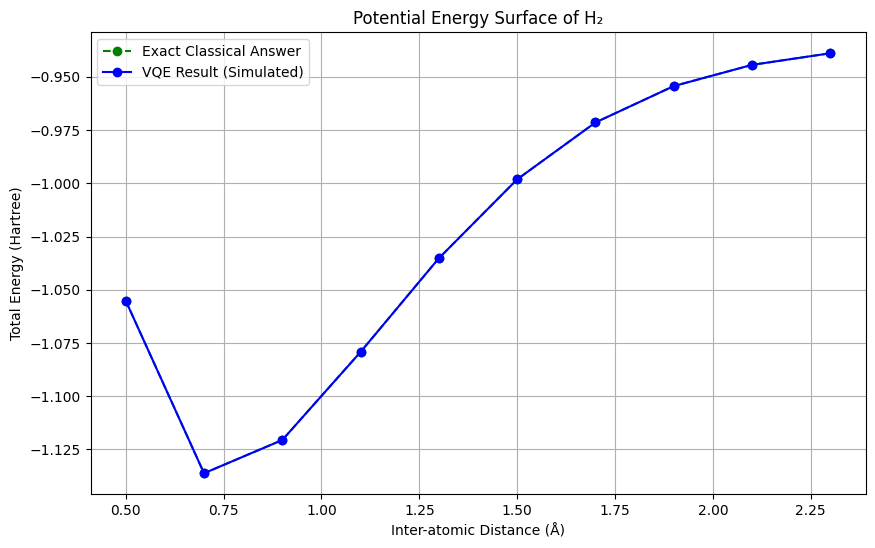

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator

# III. VQE Implementation

# --- 3a. Define the components from your image ---

# 1. The "Quantum" Part: Ansatz
# We'll use the "simpler EfficientSU2" as suggested.
# We get the number of qubits from our reduced Hamiltonian.
num_qubits = mapped_hamiltonians[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')

# 2. The "Classical" Part: Optimizer
# We'll use "SLSQP" as suggested.
optimizer = SLSQP(maxiter=1000)

# 3. The "Calculator": Estimator
# This is the "backend" that runs the circuit and calculates
# the expectation value <Psi|H|Psi>.
estimator = StatevectorEstimator()

# --- 3b. Build the VQE Solver ---
# The VQE algorithm "glues" the estimator, ansatz, and optimizer together.
vqe_solver = VQE(estimator, ansatz, optimizer)

# --- 3c. Run the VQE loop to find the energy for EACH distance ---
# We will store our final energy points here
vqe_energies = []
print("Running VQE calculations for each distance...")

for i in range(len(distances_to_check)):
    dist = distances_to_check[i]
    problem = list_of_quantum_problems[i]
    qubit_ham = mapped_hamiltonians[i]

    # Run the VQE algorithm!
    # This automatically does the optimization: "find the parameters (theta)
    # that minimize the expectation value"
    vqe_result = vqe_solver.compute_minimum_eigenvalue(qubit_ham)
    
    # The VQE result is *only* the electronic energy
    vqe_electronic_energy = vqe_result.eigenvalue.real
    
    # We must add the nuclear repulsion energy (a simple classical value)
    # to get the *total* energy of the molecule.
    nuclear_repulsion_energy = problem.hamiltonian.nuclear_repulsion_energy
    total_energy = vqe_electronic_energy + nuclear_repulsion_energy
    
    vqe_energies.append(total_energy)
    print(f"  Distance: {dist:.2f} Å, Total Energy: {total_energy:.6f} Hartree")


# --- For comparison: Let's solve it "Exactly" with a classical solver ---
# This uses the NumPy solver, which doesn't use VQE. It just finds the
# mathematically perfect answer. This is our "ground truth."
print("\nRunning classical solver for comparison...")
exact_energies = []
for i, problem in enumerate(list_of_quantum_problems):
    solver = GroundStateEigensolver(
        problem.get_tapered_mapper(mapper_type),
        NumPyMinimumEigensolver(),
    )
    result = solver.solve(problem)
    exact_energies.append(result.total_energies[0])
print("Classical solver finished.")


# --- 3d. Plot the Final Potential Energy Surface ---
print("\nPlotting results...")
plt.figure(figsize=(10, 6))
plt.plot(distances_to_check, exact_energies, 'go--', label='Exact Classical Answer')
plt.plot(distances_to_check, vqe_energies, 'bo-', label='VQE Result (Simulated)')
plt.xlabel('Inter-atomic Distance (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('Potential Energy Surface of H₂')
plt.legend()
plt.grid(True)
plt.show()